- Student 1: MANSARD Diane
- Student 2: POTTIER Clément

# Deep learning in finance

## Deep Hedging

Stefano De Marco

## Deep Hedging under log-normal dynamics


In [10]:
import numpy as np
import tensorflow as tf
import scipy.stats as sps

import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

from keras.layers import Subtract, Multiply, Lambda, Add, Concatenate

from keras import initializers

import matplotlib.pyplot as plt

In [11]:
T = 1 # maturity (in years)
N = 100 # number of time steps
mu1 = 0.025
mu2 = -0.01
sigma1 = 0.22
sigma2 = 0.3
rho = 0.5

S0_1 = 1 # initial value of the asset (in Euros)
S0_2 = 1 # initial value of the asset (in Euros)
strike = 1  # g(S) = (S-K)^+ = call option payoff
r = 0.04 # risk-free interest rate

Let's construct the training set

In [14]:
grid = [(i/N)*T for i in range(N+1)] # times t_0, t_1, ..., t_N = T
Delta_T = T/N

# Covariance matrix
cov_matrix = np.array([[1, rho], [rho, 1]])

# Cholesky decomposition of the covariance matrix
chol_matrix = np.linalg.cholesky(cov_matrix)

N_train = 10**5 # number of trajectories in the training set

# Generate correlated Gaussian increments
gaussian_increments = np.random.normal(loc=0, scale=1, size=(N, N_train, 2))
correlated_increments = np.dot(gaussian_increments, chol_matrix)

# Compute log-increments
log_increments_1 = mu1 * Delta_T + sigma1 * np.sqrt(Delta_T) * correlated_increments[:, :, 0]
log_increments_2 = mu2 * Delta_T + sigma2 * np.sqrt(Delta_T) * correlated_increments[:, :, 1]

# Reshape log_increments to match the other arrays
log_increments_1 = log_increments_1.reshape(N, N_train, 1)
log_increments_2 = log_increments_2.reshape(N, N_train, 1)

# The variable xtrain contains:
# the initial asset price S0;
# the initial value of delta hedging part of the portfolio (which is set to zero);
# a grid of points over which the model can output the hedging strategy, for plotting purposes;
# initial guesses for the option premium at time zero (which we simply set to zero);
# the increments of the log price process.

# Concatenation of lists via the operator +
strikes_1 = np.concatenate((
    S0_1 * np.ones((1, N_train, 1)),  # Add a new axis to match the shape
    np.zeros((1, N_train, 1)),
    S0_1 * np.linspace(0.5, 1.5, N_train).reshape(1, N_train, 1),  # Reshape to match dimensions
    np.zeros((1, N_train, 1)),
    log_increments_1  # Already has shape (N, N_train, m)
), axis=0)

strikes_2 = np.concatenate((
    S0_2 * np.ones((1, N_train, 1)),
    np.zeros((1, N_train, 1)),
    S0_2 * np.linspace(0.5, 1.5, N_train).reshape(1, N_train, 1),
    np.zeros((1, N_train, 1)),
    log_increments_2
), axis=0)

xtrain = [np.concatenate([strikes_1[i, :, :], strikes_2[i, :, :]], axis=-1) for i in range(104)]

# ytrain is just zero everywhere
ytrain = np.zeros((N_train, 1))

Let us plot a batch of trajectories coming from the training set:

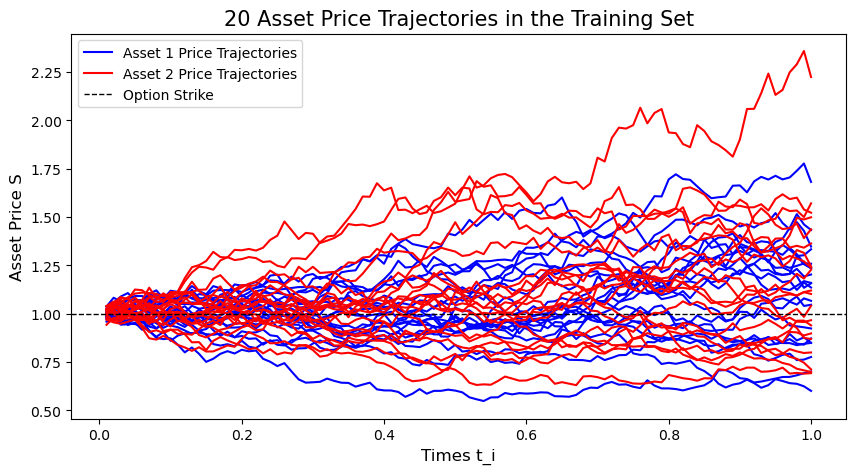

In [15]:
############################################################
## Let us plot the first M trajectories in the training set
#############################################################
# Number of trajectories to plot
M = 20

# We select the log increments to plot
log_increments_1_to_plot = np.array(log_increments_1)[:, 0:M, 0] # time step, N_train trajectories
log_increments_2_to_plot = np.array(log_increments_2)[:, 0:M, 0] # time step, N_train trajectories

# Construct the asset price trajectories from the log-increments
trajectories_1_to_plot = S0_1 * np.exp(np.cumsum(log_increments_1_to_plot, axis=0))
trajectories_2_to_plot = S0_2 * np.exp(np.cumsum(log_increments_2_to_plot, axis=0))

plt.figure(figsize=(10,5))

# Plot asset 1 trajectories
for i in range(M):
    plt.plot(grid[1:], trajectories_1_to_plot[:, i], color="b")

# Plot asset 2 trajectories
for i in range(M):
    plt.plot(grid[1:], trajectories_2_to_plot[:, i], color="r")

# Add a single legend entry for each color
plt.plot([], color="b", label="Asset 1 Price Trajectories")
plt.plot([], color="r", label="Asset 2 Price Trajectories")

plt.axhline(strike, linestyle='--', linewidth=1.0, color="k", label="Option Strike")

plt.title(f"{M} Asset Price Trajectories in the Training Set", fontsize=15)
plt.xlabel("Times t_i", fontsize=12)
plt.ylabel("Asset Price S", fontsize=12)
plt.legend()
plt.show()

Definition of the neural networks for the hedging strategies

In [16]:
d = 3 # number of layers in the NN for the hedging strategy (including the output layer)
n = 32  # nodes in the first but last layers (the output dimension of the last layer is the desired dimension for the delta)
m = 2 # dimension of the asset price process

#################################################################
# The architecture is the same for all networks (that is, for all times t_j)
#################################################################
layers = []

# loop over the time-steps
for j in range(N):
  # loop over the network layers
    for k in range(d):
        if k < d-1:
            nodes = n
            layer = keras.layers.Dense(units = nodes, activation='tanh', trainable=True,
                      kernel_initializer = initializers.RandomNormal(0,1),
                      bias_initializer = 'random_normal',
                      name=str(k)+str(j))
        else:
            ###############################################
            # TO DO: add a densely connected output layer
            # with the appropriate number of nodes
            # and a linear activation function
            ###############################################
            nodes = m
            layer = keras.layers.Dense(units = nodes, activation='sigmoid', trainable=True,
                      kernel_initializer = initializers.RandomNormal(0,1),
                      bias_initializer = 'random_normal',
                      name=str(k)+str(j))
        layers = layers + [layer]

Let construct the deep hedging model.

In [17]:
#########################################
# Construction of the deep hedging model
#########################################
# The inputs will be contained in the training set above
price = keras.Input(shape=(m,))  # initial asset price
hedge = keras.Input(shape=(m,)) # initial value of the delta portion of the portfolio
hedge_eval = keras.Input(shape=(m,)) # for plotting purposes: points over which the model can be asked to output the hegding strategy
premium = keras.Input(shape=(m,)) # initial option premium

# Concatenation of lists
inputs = [price] + [hedge] + [hedge_eval] + [premium]
output_helper = [] # this variable will allow us to output the final hedging strategy after training (once again, for plotting purposes)

premium = keras.layers.Dense(units = 1, activation='linear', trainable=True,
                            kernel_initializer=initializers.RandomNormal(0,1),
                            bias_initializer=initializers.RandomNormal(0,1))(premium)

# loop over the time steps
for j in range(N):
    strategy = price
    strategy_eval = hedge_eval

    # loop over the network layers
    for k in range(d):
        strategy = layers[k + j * d](strategy) # strategy for index j is the hedging strategy at time t_j, i.e. the neural network h_j from the lectures
        strategy_eval = layers[k + j * d](strategy_eval) # we want to evaluate the same strategy! Simply on the points of our grid, instead of the asset trajectories

    incr = keras.Input(shape=(m,)) # additional input variable: the single log-increment between t_j and t_{j+1} (dimension = m)
    inputs = inputs + [incr]

    # The instruction Lambda(lambda x : g(x)) wraps the function lambda into a Keras layer object
    # Similarly, the instructions Add(), Subtract(), and Multiply() apply binary operations to Keras layer objects
    logprice = Lambda(lambda x : tf.math.log(x))(price)
    logprice = Add()([logprice, incr])

    pricenew = Lambda(lambda x : tf.math.exp(x))(logprice) # creating the price at time j+1 by exponentiation

    priceincr = Subtract()([pricenew, price]) # the asset price increment S_{j+1} - S_j

    hedgenew = Multiply()([strategy, priceincr])

    # Calculate the cash portion of the portfolio
    delta_value = Lambda(lambda x: tf.reduce_sum(x, axis=-1, keepdims=True), output_shape=lambda s: s)(Multiply()([strategy, price]))

    cash_portion = Subtract()([premium, delta_value])

    # Convert the scalar to a tensor
    interest_rate_tensor = tf.constant(r * (T / N), shape=(1, 1), dtype=tf.float32)

    # Calculate the interest earned on the cash portion
    interest = Multiply()([cash_portion, interest_rate_tensor])

    hedge = Add()([hedge, hedgenew, interest]) # building up the delta-hedging part of the portfolio

    output_helper = output_helper + [strategy_eval]

    price = pricenew # update the asset price

# The payoff of the option at maturity
S0_tensor = tf.constant(S0_1 * S0_2, dtype=tf.float32)
initial_prices = Lambda(lambda x: x[0, :])(price)  # Store the initial prices for payoff calculation
payoff = Lambda(lambda x: (x[:, 0] * x[:, 1] / S0_tensor) - 1)(price)  # payoff of the option at maturity

outputs = Add()([premium, hedge])
outputs = Subtract()([outputs, payoff]) # our first output: option premium + delta hedge - option payoff

# This is the point where we construct the model output:
# hedging error + hedging strategy evaluated over the points of our fixed grid + option premium
outputs = [outputs] + output_helper + [premium]
outputs = Concatenate()(outputs)

model_hedge_strat = keras.models.Model(inputs = inputs, outputs = outputs)

In [18]:
def custom_loss(y_true, y_pred):
    ############################################################
    # Note we just use the first part of the model output
    # (that is to say, the total hedge minus the payoff).
    ############################################################
    z = y_pred[:, 0] - y_true[:, 0]

    # TO DO: evaluate z^2
    z = Lambda(lambda x : x**2 )(z)

    # TO DO: evaluate the mean of z. This will be our mean square loss.
    z = Lambda(lambda x : tf.math.reduce_mean(x) )(z)

    return z

In [19]:
model_hedge_strat.compile(optimizer='adam', loss = custom_loss)

In [20]:
model_hedge_strat.fit(x = xtrain, y = ytrain, epochs=5, verbose=True, batch_size=128)

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 101ms/step - loss: 0.1487
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 95s 122ms/step - loss: 0.1022
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - loss: 0.1017
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 77s 98ms/step - loss: 0.1002
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 95ms/step - loss: 0.0998


In [21]:
#Let us evaluate the model output over the training set
model_output = model_hedge_strat.predict(xtrain)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step


$\blacktriangleright$ Let us evaluate the performance of the deep model: we display the histogram of the hedging error over the training set.
Recall that

hedging error =  delta hedge + option premium - payoff.

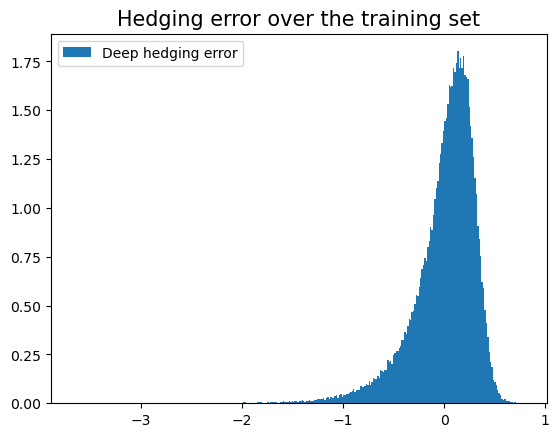

Deep hedging error sample average: -1.518e-03
Deep hedging error standard deviation: 3.169e-01 
 
Average option premium over the training set: 0.1139


In [22]:
hedging_error = model_output[:, 0]

plt.hist(hedging_error, bins=int(np.sqrt(N_train)), density=True, label="Deep hedging error")
plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("Deep hedging error sample average: %1.3e" % np.mean(hedging_error))
print("Deep hedging error standard deviation: %1.3e \n " % np.std(hedging_error))

output_option_premium = model_output[:, -1]
print("Average option premium over the training set: %1.4f" % np.mean(output_option_premium))
#print("Compare with the true Black-Scholes price : %1.4f \n" %priceBS)


How does the result look like?

The deep hedging error is centered in zero. It is small. It does not look bad, it is a satisfactory result, but we need to compare it the the Black-Scholes hedging error to assess it's precision. 

On the training set first:

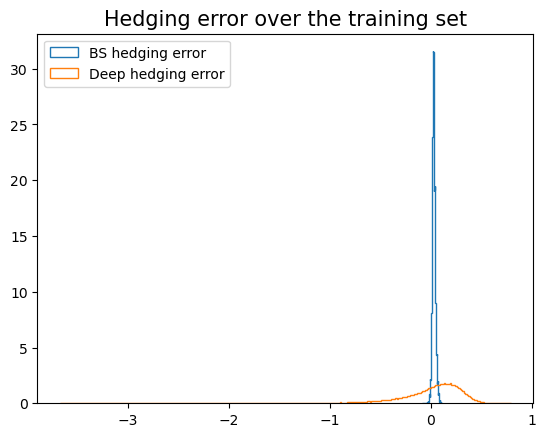

BS hedging error sample average: 2.620e-02
BS hedging error standard deviation: 1.562e-02 
 


In [23]:
log_S1 = np.log(S0_1)
log_S2 = np.log(S0_2)

mu_prod = mu1 + mu2
sigma_prod = np.sqrt(sigma1**2 + sigma2**2 + 2 * rho * sigma1 * sigma2)
S0_prod = S0_1 * S0_2

priceBS = S0_prod * sps.norm.cdf((np.log(S0_prod / (S0_prod)) + (r + 0.5 * sigma_prod**2) * T) / (sigma_prod * np.sqrt(T))) \
        - S0_prod * np.exp(-r * T) * sps.norm.cdf((np.log(S0_prod / (S0_prod)) + (r - 0.5 * sigma_prod**2) * T) / (sigma_prod * np.sqrt(T)))

price_1 = S0_1 * np.ones((N_train, N))
price_2 = S0_2 * np.ones((N_train, N))
hedge_BS = np.zeros(N_train)

for k in range(N-1):
    price_1[:, k+1] = price_1[:,k] * np.exp(log_increments_1[k,:,0])
    price_2[:, k+1] = price_2[:,k] * np.exp(log_increments_2[k,:,0])
    
    prod = price_1[:, k] * price_2[:, k]  # product of the assets
    tau = T - grid[k]
    
    d1_prod = (np.log(prod / (S0_1 * S0_2)) + 0.5 * sigma_prod**2 * tau) / (sigma_prod * np.sqrt(tau))
    delta_prod = sps.norm.cdf(d1_prod)

    hedge_BS += delta_prod * (
        price_1[:, k+1] * price_2[:, k+1] - price_1[:, k] * price_2[:, k]
    )

payoff = np.maximum(price_1[:, -1] * price_2[:, -1] / (S0_1 * S0_2) - 1, 0)
hedging_error_BS = priceBS + hedge_BS - payoff

plt.hist(hedging_error_BS, bins=int(np.sqrt(N_train)), density=True, histtype='step', label="BS hedging error")
plt.hist(hedging_error, bins=int(np.sqrt(N_train)), density=True, histtype='step', label="Deep hedging error")
plt.title("Hedging error over the training set", fontsize=15)
plt.legend(loc="best")
plt.show()

print("BS hedging error sample average: %1.3e" % np.mean(hedging_error_BS))
print("BS hedging error standard deviation: %1.3e \n " % np.std(hedging_error_BS))

$\blacktriangleright$ Is the error better? How much better with respect to the one of the deep hedging model?

The BS error is way more clother to zero than the deep-hedging one. 
It is more precise and less volatile.

<p style="color: red;">- Potentiellement repasser au modèle avec l'output linear --> plus performant. Sinon on peut aussi entrainer et plot les 2, ça prend 2 sec et on comment les résultats. </p>

After the traning, we define a test set and compare the hedging strategy predicted by the model with the theoritical BS hedging strategy $\delta(t,S_t) = N(d_1(t,S_t))$ where $d_1(t,S_t) = \frac{\log \frac{S_t}K}{\sigma \sqrt{T-t}} + \frac 12 \sigma \sqrt{T-t}$, over the grid of points in the test set.

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step


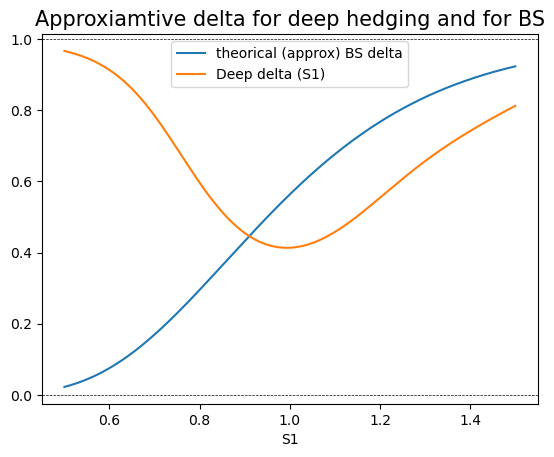

In [24]:
N_test = 10000
hedge_eval_grid = np.linspace(0.5, 1.5, N_test)
S1_test = hedge_eval_grid.reshape(N_test, 1)
S2_test = np.ones_like(S1_test)  # S2 fixé à 1

log_increments_test = [np.zeros((N_test, 2)) for _ in range(N)]

xtest = ([np.concatenate([S1_test, S2_test], axis=1)]
         + [np.zeros((N_test, 2))]  # delta hedge init
         + [np.concatenate([S1_test, S2_test], axis=1)]
         + [np.zeros((N_test, 2))]  # option premium
         + log_increments_test)

l = 50
tau = T - grid[l]
prod_test = S1_test[:, 0] * S2_test[:, 0]
d1_prod = (np.log(prod_test / (S0_1 * S0_2)) + 0.5 * sigma_prod**2 * tau) / (sigma_prod * np.sqrt(tau))
BS_delta = sps.norm.cdf(d1_prod)

model_delta = model_hedge_strat.predict(xtest)[:, l-1]  # delta sur l'actif S1

plt.plot(S1_test[:, 0], BS_delta, label="theorical (approx) BS delta")
plt.plot(S1_test[:, 0], model_delta, label="Deep delta (S1)")
plt.title("Approxiamtive delta for deep hedging and for BS", fontsize=15)
plt.xlabel("S1")
plt.axhline(0, linestyle="--", linewidth=0.5, color="k")
plt.axhline(1, linestyle="--", linewidth=0.5, color="k")
plt.legend()
plt.show()